In [1]:
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

In [3]:
GSE88884_matrix = pd.read_csv('/data/scPAFA_paper_formal/lupus/data_for_machine_learning/20240104_GSE88884_data_for_svm.csv',index_col=0)

In [4]:
len(GSE88884_matrix)

1820

In [4]:
#fearture
X = GSE88884_matrix.iloc[:,:(GSE88884_matrix.shape[1]-1)].values
#result
y = GSE88884_matrix.iloc[:,(GSE88884_matrix.shape[1]-1)].values
# 将数据集 X 和目标 y 划分成训练集和测试集,按0.3的比例
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023,stratify=y)

In [5]:
#分别scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [6]:
from sklearn.model_selection import cross_val_score
#选择超参数C
C_values = np.arange(0.01, 1, 0.02)  # 从0.01开始，每次增加0.03

# 初始化空列表来存储ROC-AUC分数
roc_auc_scores = []
non_zero_coef_counts = []

# 执行 4 折交叉验证，对每个 C 参数进行评估
for C in C_values:
    model = LinearSVC( penalty='l1',C = C,dual='auto',random_state=1,max_iter=10000)
    model.fit(X_train, y_train)  # 拟合模型

    # 获取非零系数的数量
    non_zero_coef = np.sum(model.coef_ != 0)
    non_zero_coef_counts.append(non_zero_coef)
    
    # 执行 4 折交叉验证，对每个 C 参数进行评估
    cv_score = cross_val_score(model, X_train, y_train, cv=4, scoring='roc_auc')  # 4 折交叉验证，使用ROC-AUC作为评分指标
    mean_score = np.mean(cv_score)
    roc_auc_scores.append(mean_score)

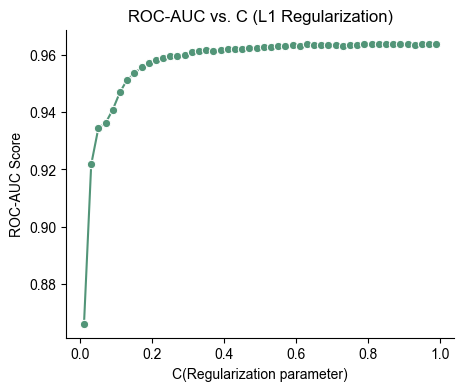

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))  # 设置图表大小

sns.lineplot(x=C_values, y=roc_auc_scores, marker='o',markersize=6,color = "#529578")
plt.title('ROC-AUC vs. C (L1 Regularization)')
plt.xlabel('C(Regularization parameter)')
plt.ylabel('ROC-AUC Score')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../lupus/figure_lupus/20240104_lupus_GSE88884_CV_ROC.pdf',bbox_inches = "tight",transparent=True)

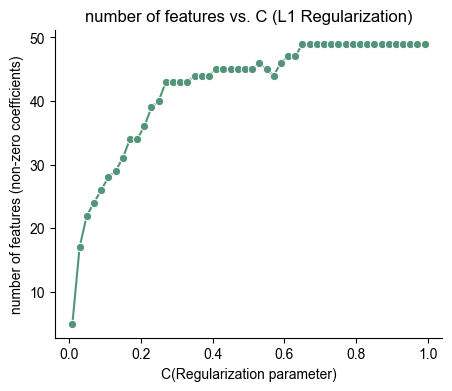

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))  # 设置图表大小

sns.lineplot(x=C_values, y= non_zero_coef_counts, marker='o',markersize=6,color = "#529578")
plt.title('number of features vs. C (L1 Regularization)')
plt.xlabel('C(Regularization parameter)')
plt.ylabel('number of features (non-zero coefficients)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../lupus/figure_lupus/20240104_lupus_GSE88884_number_of_features.pdf',bbox_inches = "tight",transparent=True)

In [9]:
# 创建线性 SVM 模型
svm_classifier = LinearSVC( penalty='l1',C = 0.01,dual='auto',random_state=1)
# 训练模型
svm_classifier.fit(X_train, y_train)
# 预测测试集
y_pred = svm_classifier.predict(X_test)
# 获取特征的权重
weights = svm_classifier.coef_
# 创建一个包含特征名称和对应权重的数据框
feature_weights_df = pd.DataFrame({'Feature': list(GSE88884_matrix.iloc[:,:(GSE88884_matrix.shape[1]-1)].columns), 'coef': np.ravel(weights)})
feature_weights_df.index = feature_weights_df['Feature']

In [10]:
# 获取非零权重的索引
nonzero_indices = np.where(weights != 0)[1]
# 通过索引获取非零权重对应的特征名称和权重
nonzero_feature_weights = feature_weights_df.iloc[nonzero_indices]

In [11]:
nonzero_feature_weights

,Feature,coef
Feature,,
bioplanet_686_Interferon alpha/beta signaling,bioplanet_686_Interferon alpha/beta signaling,0.021651
bioplanet_776_Prostaglandin biosynthesis and regulation,bioplanet_776_Prostaglandin biosynthesis and r...,0.019227
bioplanet_78_Beta-arrestins in GPCR desensitization,bioplanet_78_Beta-arrestins in GPCR desensitiz...,-0.003454
bioplanet_87_Corticosteroids and cardioprotection,bioplanet_87_Corticosteroids and cardioprotection,-0.003717
bioplanet_926_Activation of IRF3/IRF7 mediated by TBK1/IKK epsilon,bioplanet_926_Activation of IRF3/IRF7 mediated...,0.020355


ROC AUC Score: 0.9346590909090908


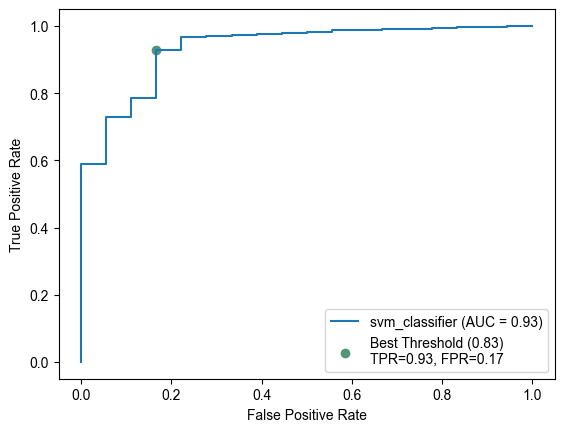

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, svm_classifier.decision_function(X_test))
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)
best_threshold = thresholds[np.argmax(tpr - fpr)]
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='svm_classifier')
display.plot()
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='o', color='#529578', label=f'Best Threshold ({best_threshold:.2f})\nTPR={tpr[np.argmax(tpr - fpr)]:.2f}, FPR={fpr[np.argmax(tpr - fpr)]:.2f}')
# 显示图例
plt.legend(loc='lower right')
plt.savefig('../lupus/figure_lupus/20240104_lupus_GSE88884_testset_ROC_AUC.pdf',bbox_inches = "tight",transparent=True)
# 显示图表
plt.show()

In [5]:
GSE61635_matrix = pd.read_csv('/data/scPAFA_paper_formal/lupus/data_for_machine_learning/20240104_GSE61635_data_for_svm.csv',index_col=0)

In [6]:
len(GSE61635_matrix)

129

ROC AUC Score: 0.9781144781144782


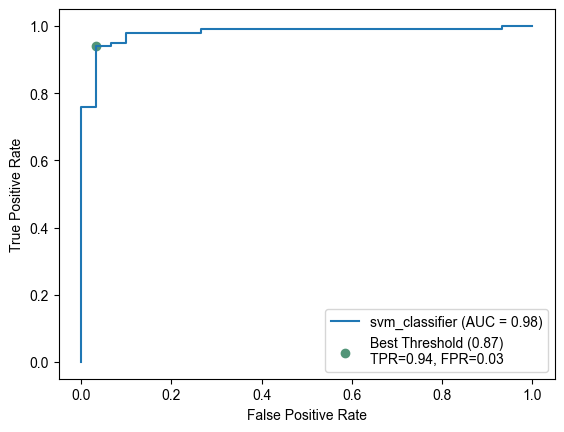

In [13]:
#用GSE61635作为外部数据集验证
GSE61635_matrix = pd.read_csv('/data/scPAFA_paper_formal/lupus/data_for_machine_learning/20240104_GSE61635_data_for_svm.csv',index_col=0)
#fearture
X_GSE61635 = GSE61635_matrix.iloc[:,:(GSE61635_matrix.shape[1]-1)].values
#result
y_GSE61635 = GSE61635_matrix.iloc[:,(GSE61635_matrix.shape[1]-1)].values

#分别scale
X_GSE61635 = scaler.fit_transform(X_GSE61635)

fpr, tpr, thresholds = roc_curve(y_GSE61635, svm_classifier.decision_function(X_GSE61635))
roc_auc = auc(fpr, tpr)

print("ROC AUC Score:", roc_auc)
best_threshold = thresholds[np.argmax(tpr - fpr)]


display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='svm_classifier')
display.plot()
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='o', color='#529578', label=f'Best Threshold ({best_threshold:.2f})\nTPR={tpr[np.argmax(tpr - fpr)]:.2f}, FPR={fpr[np.argmax(tpr - fpr)]:.2f}')
# 显示图例
plt.legend(loc='lower right')
# 显示图表
plt.savefig('../lupus/figure_lupus/20240104_lupus_GSE61635_ROC_AUC.pdf',bbox_inches = "tight",transparent=True)
plt.show()

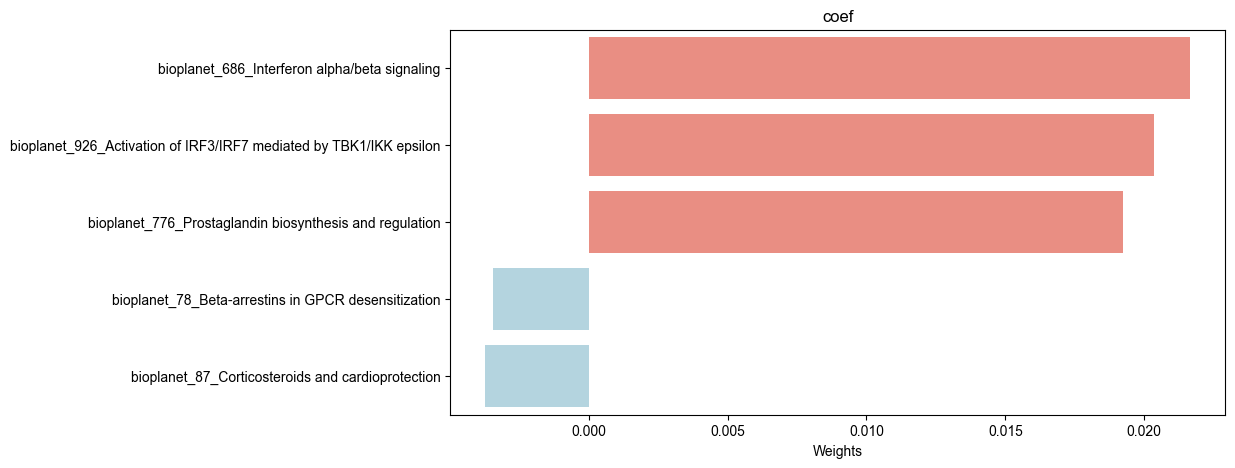

In [14]:
import scPAFA
a1 = scPAFA.pl.plot_weights_butterfly(nonzero_feature_weights,factor_name='coef',n_largest=2,n_smallest=3,label_beside_bar=False,figsize=(10,5))
a1.savefig('../lupus/figure_lupus/20240104_bulk_svm_coef_butterfly.pdf',bbox_inches = "tight",transparent=True)